In [3746]:
import sqlite3
import pandas as pd
import re


In [3748]:
db_path = 'logs.db'

# первый этап (4-6 мая)

In [4167]:
conn = sqlite3.connect(db_path)

In [4169]:
query = "SELECT * FROM user_logs WHERE timestamp >= '2025-05-04 17:00:00' and timestamp <= '2025-05-06 12:00:00' "

df = pd.read_sql_query(query, conn)

df.head()

,id,user_id,action,timestamp
0,537,9c83e325-7760-49c3-b19a-683af70998f9,"Зашел на сайт, вариант B",2025-05-04 17:00:52
1,538,874fa216-322b-45fd-a0c0-d804fde5107f,"Зашел на сайт, вариант A",2025-05-04 17:01:14
2,539,10bea1dc-101d-4d04-b80c-d8bd58818eed,"Зашел на сайт, вариант B",2025-05-04 17:01:16
3,540,75af4812-61d1-4b3c-ba58-bd0775681478,"Зашел на сайт, вариант A",2025-05-04 17:01:25
4,541,ed55dddf-7582-43f9-8bb8-09e7cbf712f6,"Зашел на сайт, вариант B",2025-05-04 17:01:25


In [4171]:
query = "SELECT * FROM user_variants "

user_variants = pd.read_sql_query(query, conn)

df.head()

,id,user_id,action,timestamp
0,537,9c83e325-7760-49c3-b19a-683af70998f9,"Зашел на сайт, вариант B",2025-05-04 17:00:52
1,538,874fa216-322b-45fd-a0c0-d804fde5107f,"Зашел на сайт, вариант A",2025-05-04 17:01:14
2,539,10bea1dc-101d-4d04-b80c-d8bd58818eed,"Зашел на сайт, вариант B",2025-05-04 17:01:16
3,540,75af4812-61d1-4b3c-ba58-bd0775681478,"Зашел на сайт, вариант A",2025-05-04 17:01:25
4,541,ed55dddf-7582-43f9-8bb8-09e7cbf712f6,"Зашел на сайт, вариант B",2025-05-04 17:01:25


In [4173]:
# Закрыть подключение
conn.close()

In [4175]:
control = user_variants[user_variants['variant'] == 'A']
control.columns = ['user_id', 'group']
control['group'] = 'control'

test = user_variants[user_variants['variant'] == 'B']
test.columns = ['user_id', 'group']
test['group'] = 'test'

/var/folders/nr/dvkhlk7923z7lxh9kjf4zm1m0000gn/T/ipykernel_50384/3845673803.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control['group'] = 'control'
/var/folders/nr/dvkhlk7923z7lxh9kjf4zm1m0000gn/T/ipykernel_50384/3845673803.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['group'] = 'test'


In [4179]:
def extract_features(text):
    age_match = re.search(r'возраст=(\d+)', text)
    exp_match = re.search(r'опыт=([a-zA-Zа-яА-Я]+)', text)
    result_rating = re.search(r'удовлетворённость результатом=(\d+)', text)
    comfort_rating = re.search(r'удобством=(\d+)', text)
    liked_match = re.search(r'понравилось=([^,]+)', text)
    problems_match = re.search(r'проблемы=([^,]+)', text)

    return pd.Series({
        'age': int(age_match.group(1)) if age_match else None,
        'exp': exp_match.group(1) if exp_match else None,
        'result': int(result_rating.group(1)) if result_rating else None,
        'comfort': int(comfort_rating.group(1)) if comfort_rating else None,
        'liked': liked_match.group(1).strip() if liked_match else None,
        'problems': problems_match.group(1).strip() if problems_match else None
    })


In [4181]:
feedback = df[df['action'].str.contains('Обратная связь')]
feedback = feedback.join(df['action'].apply(extract_features))
feedback = feedback.drop_duplicates('user_id', keep = 'last')
users_df = pd.concat([control, test])
users_df = users_df.merge(feedback, on = 'user_id')

In [4183]:
print('всего пользователей в контроле: ', len(users_df[users_df['group'] == 'control']))
print('всего пользователей в тесте: ', len(users_df[users_df['group'] == 'test']))

всего пользователей в контроле:  58
всего пользователей в тесте:  57


In [4185]:
users_df['age'].mean()

36.6695652173913

In [3817]:
users_df['age'].std()

9.5950661107131

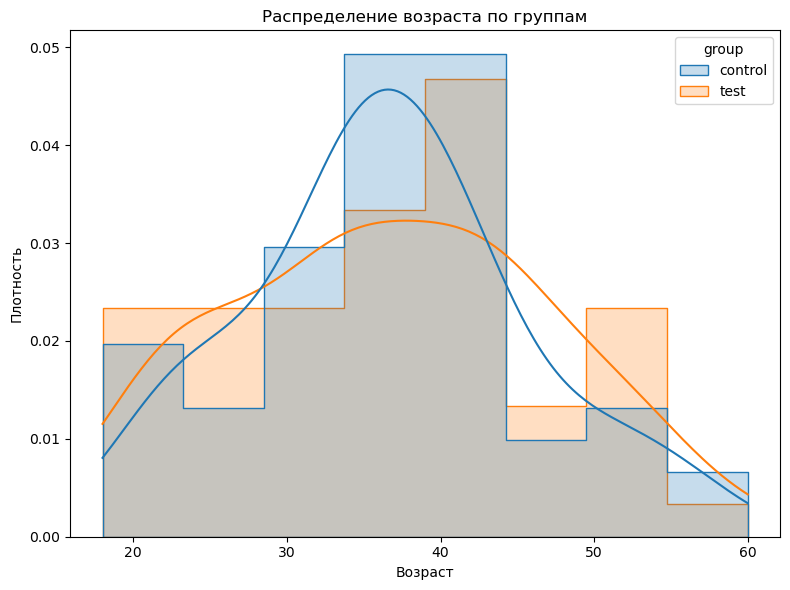

In [3809]:
plt.figure(figsize=(8, 6))
sns.histplot(data=users_df, 
                 x='age', 
                 hue='group', kde=True, element='step', stat='density', common_norm=False)
plt.title(f'Распределение возраста по группам')
plt.xlabel('Возраст')  
plt.ylabel('Плотность')  
plt.title('Распределение возраста по группам')
plt.tight_layout()
plt.show()

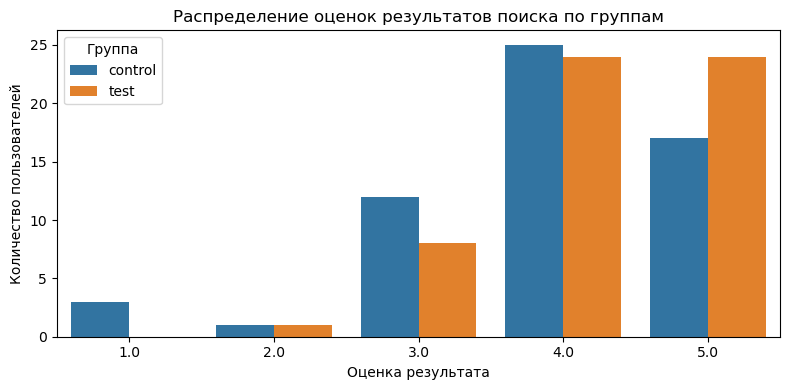

In [3811]:
# Считаем количество пользователей для каждой оценки результата в каждой группе
grouped = users_df.groupby(['group', 'result']).size().reset_index(name='count')

# Строим barplot
plt.figure(figsize=(8, 4))
ax = sns.barplot(data=grouped, x='result', y='count', hue='group')

plt.xlabel('Оценка результата')
plt.ylabel('Количество пользователей')
plt.title('Распределение оценок результатов поиска по группам')
plt.legend(title='Группа', loc='upper left', bbox_to_anchor=(0, 1))
plt.tight_layout()
plt.show()

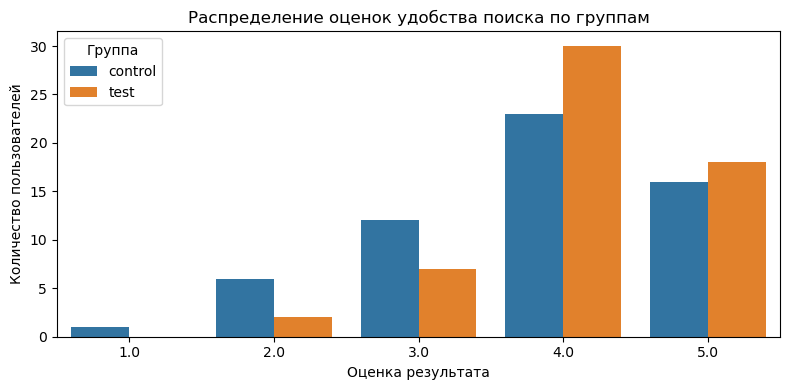

In [3664]:
# Считаем количество пользователей для каждой оценки результата в каждой группе
grouped = users_df.groupby(['group', 'comfort']).size().reset_index(name='count')

# Строим barplot
plt.figure(figsize=(8, 4))
ax = sns.barplot(data=grouped, x='comfort', y='count', hue='group')

plt.xlabel('Оценка результата')
plt.ylabel('Количество пользователей')
plt.title('Распределение оценок удобства поиска по группам')
plt.legend(title='Группа', loc='upper left', bbox_to_anchor=(0, 1))
plt.tight_layout()
plt.show()

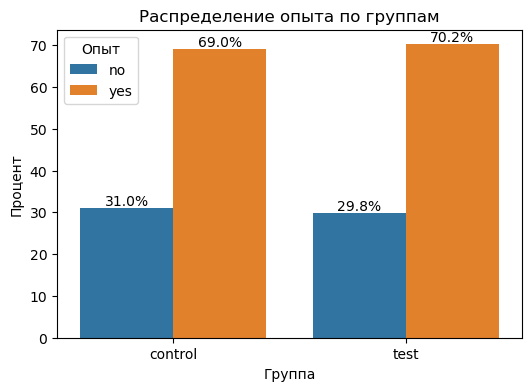

In [3819]:
exp_dist = users_df.groupby(['group', 'exp']).size().reset_index(name='count')
exp_dist['percent'] = exp_dist['count'] / exp_dist.groupby('group')['count'].transform('sum') * 100

# Построение графика
plt.figure(figsize=(6, 4))
ax = sns.barplot(data=exp_dist, x='group', y='percent', hue='exp')

# Названия осей и заголовок
plt.title('Распределение опыта по группам')
plt.ylabel('Процент')
plt.xlabel('Группа')

# Изменение заголовка легенды
ax.legend(title='Опыт')  # ← вот здесь задается заголовок легенды

# Добавление значений к столбцам
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='edge')  # edge = сверху, можно 'center' или 'inside'

plt.show()

In [3825]:
df_entry = df[df['action'].str.contains('Зашел на сайт', na=False)].copy()
df_search = df[df['action'].str.contains('Поиск:', na=False)].copy()
df_booking = df[df['action'].str.contains('забронировал жильё', na=False)].copy()

df_search['timestamp'] = pd.to_datetime(df_search['timestamp'])
df_entry['timestamp'] = pd.to_datetime(df_entry['timestamp'])
df_booking['timestamp'] = pd.to_datetime(df_booking['timestamp'])

# первый поиск 
def get_first_search_before_booking(row):
    user_searches = df_search[df_search['user_id'] == row['user_id']]
    searches_before = user_searches[user_searches['timestamp'] <= row['timestamp']]
    if not searches_before.empty:
        return searches_before['timestamp'].min()
    else:
        return pd.NaT

# последний вход перед бронированием
def get_last_entry_before_booking(row):
    user_entries = df_entry[df_entry['user_id'] == row['user_id']]
    entries_before = user_entries[user_entries['timestamp'] <= row['timestamp']]
    if not entries_before.empty:
        return entries_before['timestamp'].min()
    else:
        return pd.NaT

df_booking['last_entry_time'] = df_booking.apply(get_last_entry_before_booking, axis=1)
df_booking['first_search_time'] = df_booking.apply(get_first_search_before_booking, axis=1)

df_booking['time_diff_entry'] = (df_booking['timestamp'] - df_booking['last_entry_time']).dt.total_seconds()
df_booking['time_diff_search'] = (df_booking['timestamp'] - df_booking['first_search_time']).dt.total_seconds()

df_booking_clean = df_booking[['user_id', 'time_diff_entry', 'time_diff_search']].drop_duplicates('user_id')
# df_booking_clean = df_booking[df_booking['last_search_time'].notna()]

In [3827]:
users_df = users_df.merge(df_booking_clean, on = 'user_id', how = 'left')

In [3829]:
users_df = users_df[['user_id', 'group', 'age', 'exp', 'result', 'comfort',
       'time_diff_entry', 'time_diff_search', 'liked', 'problems']]
users_df.columns = ['user_id', 'group', 'age', 'exp', 'result', 'comfort',
       'time_diff_entry', 'time_diff_search', 'liked', 'problems']

In [3841]:
for i in ['time_diff_entry', 'time_diff_search']:
    for g in ['control', 'test']:
        print(i + ' mean ' + g + ' ' + str(users_df[users_df['group'] == g][i].mean()))
        print(i + ' std ' + g + ' ' + str(users_df[users_df['group'] == g][i].std()))


time_diff_entry mean control 133.0
time_diff_entry std control 113.23938314357264
time_diff_entry mean test 151.96428571428572
time_diff_entry std test 89.52561122346533
time_diff_search mean control 81.10344827586206
time_diff_search std control 95.15374256824
time_diff_search mean test 87.56140350877193
time_diff_search std test 70.75612480905798


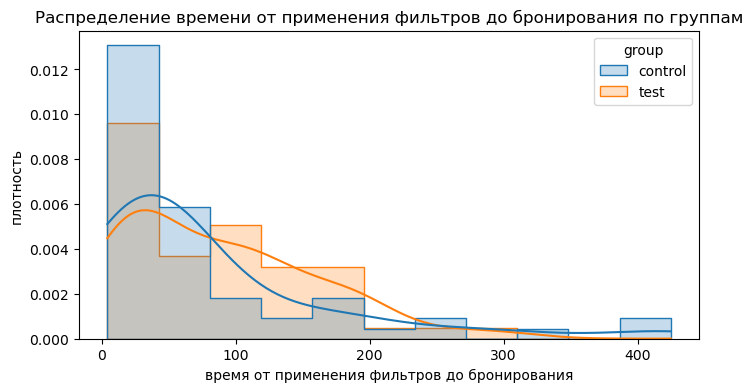

In [3694]:
plt.figure(figsize=(8, 4))
sns.histplot(data=users_df, 
                     x='time_diff_search', 
                     hue='group', kde=True, element='step', stat='density', common_norm=False)
plt.title(f'Распределение времени от применения фильтров до бронирования по группам')
plt.xlabel('время от применения фильтров до бронирования')
plt.ylabel('плотность')
plt.show()

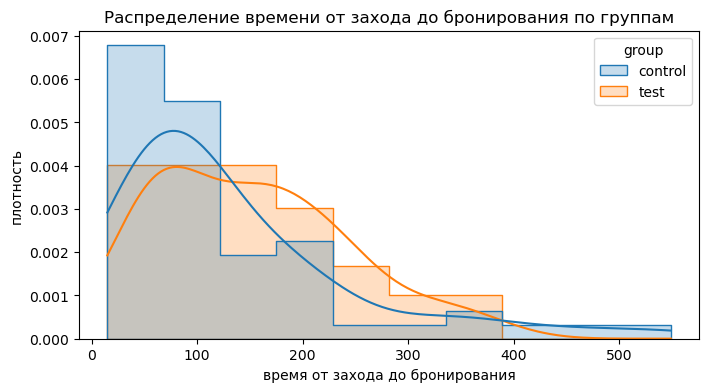

In [3843]:
plt.figure(figsize=(8, 4))
sns.histplot(data=users_df, 
                     x='time_diff_entry', 
                     hue='group', kde=True, element='step', stat='density', common_norm=False)
plt.title(f'Распределение времени от захода до бронирования по группам')
plt.xlabel('время от захода до бронирования')
plt.ylabel('плотность')
plt.show()

In [3845]:
from scipy.stats import shapiro

for group in users_df['group'].unique():
    stat, p = shapiro(users_df[users_df['group'] == group]['age'])
    print(f'{group} age: p-value={p:.4f}')

control age: p-value=0.4404
test age: p-value=0.2262


In [3847]:
from scipy.stats import levene

control_age = users_df[users_df['group'] == 'control']['age']
test_age = users_df[users_df['group'] == 'test']['age']

stat, p = levene(control_age, test_age)
print(f'Levene test (равенство дисперсий): p-value={p:.4f}')

Levene test (равенство дисперсий): p-value=0.1172


In [3849]:
from scipy.stats import ttest_ind

control_age = users_df[users_df['group'] == 'control']['age']
test_age = users_df[users_df['group'] == 'test']['age']

stat, p = ttest_ind(control_age, test_age, equal_var=True)
print(f't-test по age: p-value={p:.4f}')

t-test по age: p-value=0.8797


In [3863]:
from scipy.stats import ttest_ind

stat, p = ttest_ind(users_df[users_df['group'] == 'control']['time_diff_entry'], 
                    users_df[(users_df['group'] == 'test') & (users_df['time_diff_entry'].isna() == False)]['time_diff_entry'],
                    equal_var=True)
print(f't-test по time_diff_entry: p-value={p:.4f}')

t-test по time_diff_entry: p-value=0.3245


In [3865]:
from scipy.stats import ttest_ind

stat, p = ttest_ind(users_df[users_df['group'] == 'control']['time_diff_search'], 
                    users_df[users_df['group'] == 'test']['time_diff_search'], 
                    equal_var=True)
print(f't-test по time_diff_search: p-value={p:.4f}')

t-test по time_diff_search: p-value=0.6808


In [3869]:
users_df.groupby(['group', 'exp']).size()

group    exp
control  no     18
         yes    40
test     no     17
         yes    40
dtype: int64

In [3871]:
from statsmodels.stats.proportion import proportions_ztest
import pandas as pd

successes = [40, 40]

nobs = [58, 57]

# 4. Проведем Z-тест
z_stat, p_val = proportions_ztest(successes, nobs)

print(f"Z-статистика для result: {z_stat:.2f}, p-значение: {p_val:.4f}")

Z-статистика для result: -0.14, p-значение: 0.8879


In [3873]:
users_df = users_df[users_df['result'].isna() == False]
users_df = users_df[users_df['comfort'].isna() == False]

In [3887]:
print(f'''
результат контроль {users_df[users_df['group'] == 'control']['result'].mean()}
результат тест {users_df[users_df['group'] == 'test']['result'].mean()}
''')


результат контроль 3.896551724137931
результат тест 4.245614035087719



In [3889]:
round(4.245614035087719 - 3.896551724137931, 4)

0.3491

In [3891]:
print(f'''
результат контроль sd {users_df[users_df['group'] == 'control']['result'].std()}
результат тест sd {users_df[users_df['group'] == 'test']['result'].std()}
''')


результат контроль sd 1.0206577716117
результат тест sd 0.7625310708982372



In [3893]:
print(f'''
комфорт контроль {users_df[users_df['group'] == 'control']['comfort'].mean()}
комфорт тест {users_df[users_df['group'] == 'test']['comfort'].mean()}
''')


комфорт контроль 3.810344827586207
комфорт тест 4.12280701754386



In [3895]:
round(4.12280701754386 - 3.810344827586207, 4)

0.3125

In [3897]:
print(f'''
комфорт контроль sd {users_df[users_df['group'] == 'control']['comfort'].std()}
комфорт тест sd {users_df[users_df['group'] == 'test']['comfort'].std()}
''')


комфорт контроль sd 1.016649063150287
комфорт тест sd 0.757584871214263



In [3899]:
from statsmodels.stats.power import TTestIndPower

effect_size = 0.33/0.9
alpha = 0.05
power = 0.80

analysis = TTestIndPower()
sample_size = analysis.solve_power(effect_size=effect_size, 
                                   power=power, 
                                   alpha=alpha, 
                                   alternative='larger')
print(f"Необходимый размер выборки на группу: {sample_size:.0f}")

Необходимый размер выборки на группу: 93


# второй этап


In [4247]:
conn = sqlite3.connect(db_path)

query = "SELECT * FROM user_logs WHERE timestamp >= '2025-05-04 17:00:00'"

df = pd.read_sql_query(query, conn)

query = "SELECT * FROM user_variants "

user_variants = pd.read_sql_query(query, conn)

conn.close()

In [4249]:
control = user_variants[user_variants['variant'] == 'A']
control.columns = ['user_id', 'group']
control['group'] = 'control'

test = user_variants[user_variants['variant'] == 'B']
test.columns = ['user_id', 'group']
test['group'] = 'test'

/var/folders/nr/dvkhlk7923z7lxh9kjf4zm1m0000gn/T/ipykernel_50384/3845673803.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control['group'] = 'control'
/var/folders/nr/dvkhlk7923z7lxh9kjf4zm1m0000gn/T/ipykernel_50384/3845673803.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['group'] = 'test'


In [4251]:
feedback = df[df['action'].str.contains('Обратная связь')]
feedback = feedback.join(df['action'].apply(extract_features))
feedback = feedback.drop_duplicates('user_id', keep = 'last')
users_df = pd.concat([control, test])
users_df = users_df.merge(feedback, on = 'user_id')

print('всего пользователей в контроле: ', len(users_df[users_df['group'] == 'control']))
print('всего пользователей в тесте: ', len(users_df[users_df['group'] == 'test']))

всего пользователей в контроле:  91
всего пользователей в тесте:  96


In [4253]:
control_age = users_df[users_df['group'] == 'control']['age']
test_age = users_df[users_df['group'] == 'test']['age']

stat, p = ttest_ind(control_age, test_age, equal_var=True)
print(f't-test по age: p-value={p:.4f}')

t-test по age: p-value=0.5226


In [4255]:
users_df.groupby(['group', 'exp']).size()

group    exp
control  no     31
         yes    60
test     no     31
         yes    65
dtype: int64

In [4257]:
# 2. Кол-во успешных (good_result == 1)
successes = [60, 65]

# 3. Общее количество наблюдений в каждой группе
nobs = [90, 96]

# 4. Проведем Z-тест
z_stat, p_val = proportions_ztest(successes, nobs)

print(f"Z-статистика для result: {z_stat:.2f}, p-значение: {p_val:.4f}")

Z-статистика для result: -0.15, p-значение: 0.8798


In [4259]:
print(f'''
результат контроль {users_df[users_df['group'] == 'control']['result'].mean()}
результат тест {users_df[users_df['group'] == 'test']['result'].mean()}
''')


результат контроль 3.868131868131868
результат тест 4.270833333333333



In [4261]:
print(f'''
результат контроль sd  {users_df[users_df['group'] == 'control']['result'].std()}
результат тест sd {users_df[users_df['group'] == 'test']['result'].std()}
''')


результат контроль sd  0.9798955863740582
результат тест sd 0.7605976412859983



In [4263]:
print(f'''
удобство контроль   {users_df[users_df['group'] == 'control']['comfort'].mean()}
удобство тест {users_df[users_df['group'] == 'test']['comfort'].mean()}
''')


удобство контроль   3.7362637362637363
удобство тест 4.197916666666667



In [4265]:
print(f'''
удобство контроль sd {users_df[users_df['group'] == 'control']['comfort'].std()}
удобство тест sd {users_df[users_df['group'] == 'test']['comfort'].std()}
''')


удобство контроль sd 1.041741755535356
удобство тест sd 0.8028867871514981



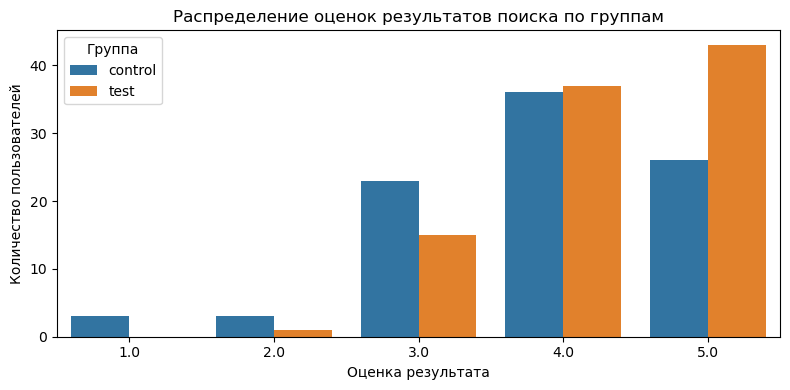

In [4277]:
# Считаем количество пользователей для каждой оценки результата в каждой группе
grouped = users_df.groupby(['group', 'result']).size().reset_index(name='count')

# Строим barplot
plt.figure(figsize=(8, 4))
ax = sns.barplot(data=grouped, x='result', y='count', hue='group')

plt.xlabel('Оценка результата')
plt.ylabel('Количество пользователей')
plt.title('Распределение оценок результатов поиска по группам')
plt.legend(title='Группа', loc='upper left', bbox_to_anchor=(0, 1))
plt.tight_layout()
plt.show()

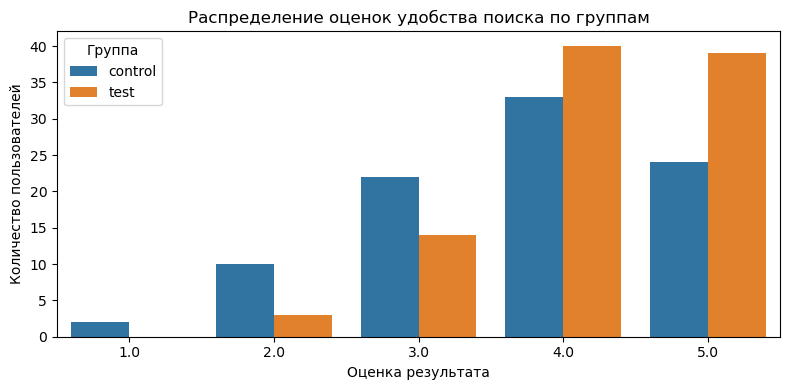

In [4269]:
# Считаем количество пользователей для каждой оценки результата в каждой группе
grouped = users_df.groupby(['group', 'comfort']).size().reset_index(name='count')

# Строим barplot
plt.figure(figsize=(8, 4))
ax = sns.barplot(data=grouped, x='comfort', y='count', hue='group')

plt.xlabel('Оценка результата')
plt.ylabel('Количество пользователей')
plt.title('Распределение оценок удобства поиска по группам')
plt.legend(title='Группа', loc='upper left', bbox_to_anchor=(0, 1))
plt.tight_layout()
plt.show()

In [4271]:
from scipy.stats import mannwhitneyu

# Для result
control_result = users_df[users_df['group'] == 'control']['result']
test_result = users_df[users_df['group'] == 'test']['result']

stat, p = mannwhitneyu(control_result, test_result, alternative='two-sided')
print(f'Mann-Whitney по result: p-value = {p:.4f}')

# Для comfort
control_comfort = users_df[users_df['group'] == 'control']['comfort']
test_comfort = users_df[users_df['group'] == 'test']['comfort']

stat, p = mannwhitneyu(control_comfort, test_comfort, alternative='two-sided')
print(f'Mann-Whitney по comfort: p-value = {p:.4f}')

Mann-Whitney по result: p-value = 0.0043
Mann-Whitney по comfort: p-value = 0.0021


In [4141]:
pip install pymystem3


Note: you may need to restart the kernel to use updated packages.


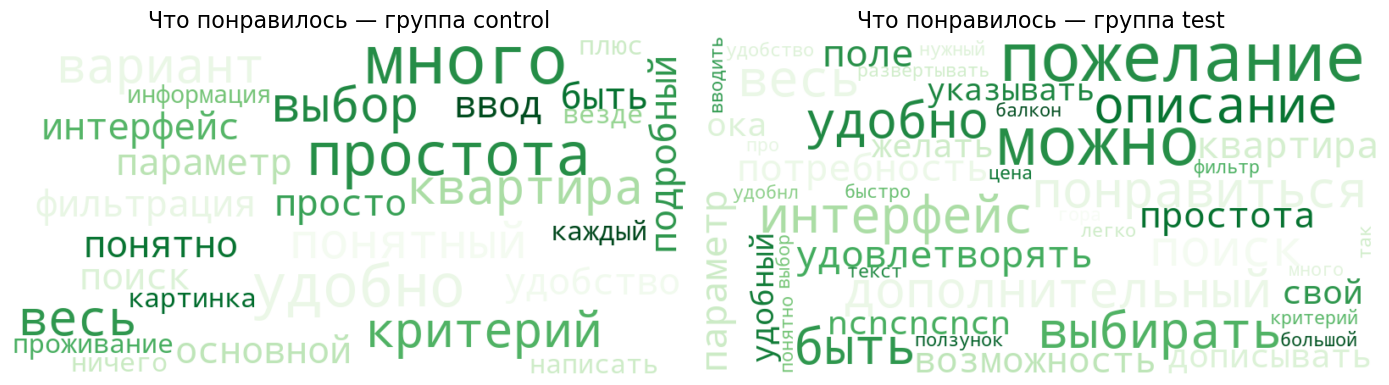

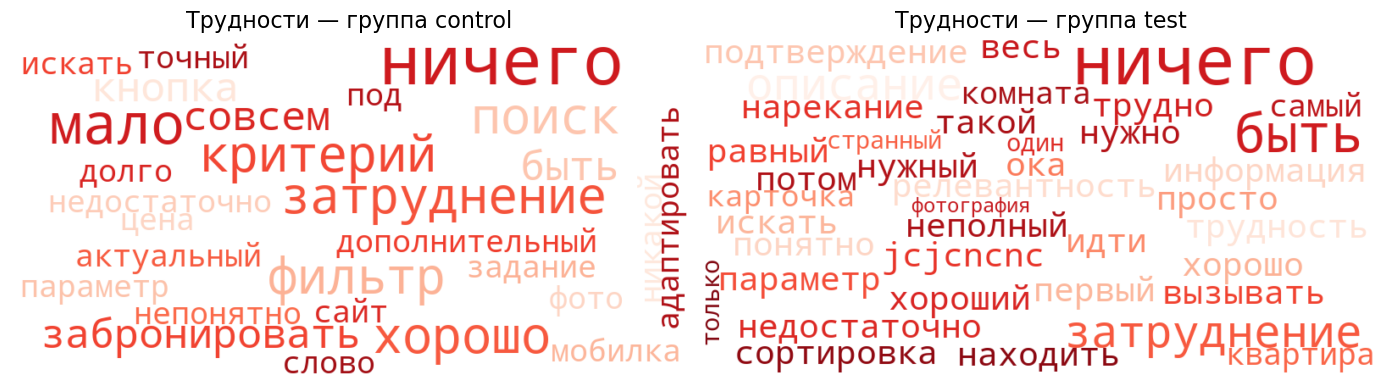

In [4151]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from pymystem3 import Mystem
import pandas as pd
import re

# Инициализируем лемматизатор
mystem = Mystem()


# Мини-список стоп-слов
custom_stopwords = set([
    "все", "ещё", "это", "на", "есть", "было", "нет", "как", "что", "где", 
    "и", "по", "от", "при", "с", "для", "также", "были", "ок", "одна", "одинаково"
])

# Очистка и лемматизация
def clean_and_lemmatize(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    lemmas = mystem.lemmatize(text)
    lemmas = [lemma for lemma in lemmas if lemma.strip().isalpha() and lemma not in custom_stopwords and len(lemma) > 2]
    return " ".join(lemmas)

# Группы и поля
groups = users_df['group'].unique()
cols = ['liked', 'problems']

# Цветовые схемы для каждой категории
colormaps = {'liked': 'Greens', 'problems': 'Reds'}

# Генерация облаков
for col in ['liked', 'problems']:
    plt.figure(figsize=(14, 6))
    for i, grp in enumerate(users_df['group'].unique(), 1):
        raw_text = users_df[users_df['group'] == grp][col].dropna().astype(str)
        cleaned_text = ' '.join([clean_and_lemmatize(t) for t in raw_text])

        wordcloud = WordCloud(
            width=800,
            height=400,
            background_color='white',
            colormap=colormaps[col],
            max_words=100,
            max_font_size=80,
            random_state=42
        ).generate(cleaned_text)

        plt.subplot(1, 2, i)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(
            f"{'Что понравилось' if col == 'liked' else 'Трудности'} — группа {grp}",
            fontsize=16,           # увеличенный размер
        )

    plt.tight_layout()
    plt.show()

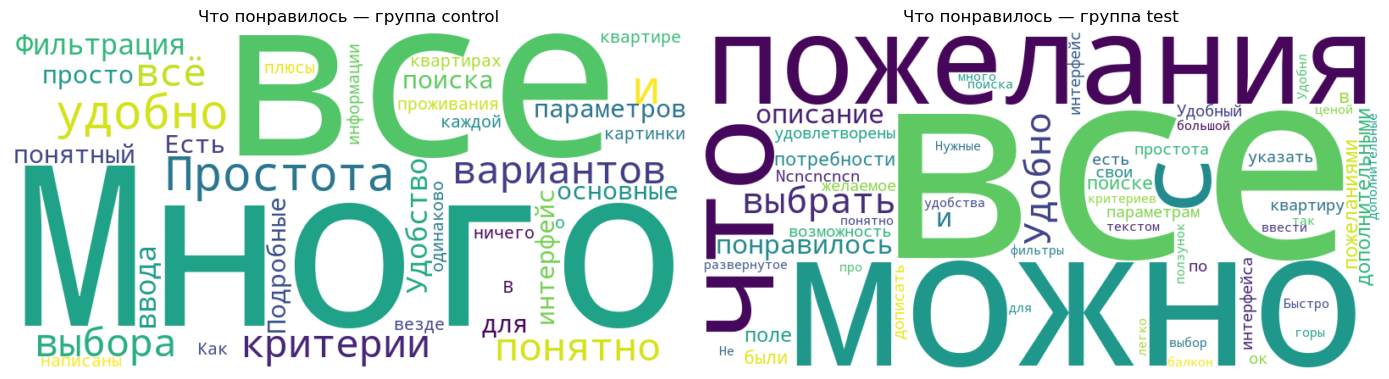

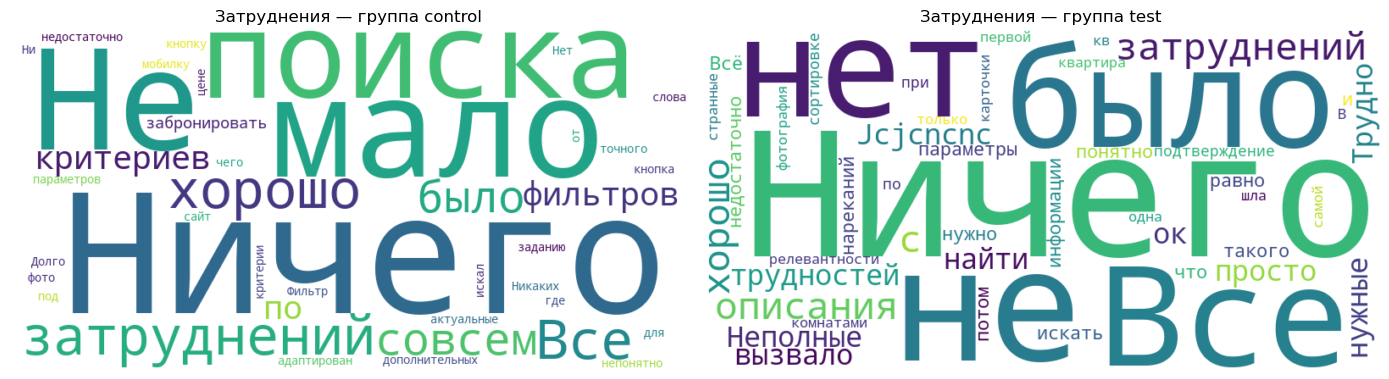

In [4102]:
groups = users_df['group'].unique()

for col in ['liked', 'problems']:
    plt.figure(figsize=(14, 6))
    for i, grp in enumerate(groups, 1):
        # Фильтруем по группе и собираем текст
        text = ' '.join(users_df[users_df['group'] == grp][col].dropna().astype(str))
        
        # Генерация облака
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
        
        # Отображение
        plt.subplot(1, 2, i)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"{'Что понравилось' if col == 'liked' else 'Затруднения'} — группа {grp}")
    
    plt.tight_layout()
    plt.show()

In [4114]:
len(users_df[(users_df['liked'].isna()==False) & (users_df['group'] == 'control')])

24

In [4110]:
users_df[(users_df['liked'].isna()==False) & (users_df['group'] == 'control')]

,user_id,group,id,action,timestamp,age,exp,result,comfort,liked,problems
60,9f0c21fb-8e86-48dd-9d55-08efe0e47d50,control,1944,"Обратная связь: возраст=23, опыт=no, удовлетво...",2025-05-18 07:36:29,23.0,no,5.0,5.0,Простота,Ничего
61,df53f8f9-f1d9-44b1-8d6b-8a76557a1953,control,2002,"Обратная связь: возраст=37, опыт=yes, удовлетв...",2025-05-18 08:18:38,37.0,yes,4.0,4.0,Удобно,Не совсем актуальные критерии поиска
62,3f52227f-bda4-45fe-ba21-df7f0611537d,control,1986,"Обратная связь: возраст=29, опыт=yes, удовлетв...",2025-05-18 08:16:57,29.0,yes,4.0,4.0,Много вариантов,Ничего
63,96828192-98ba-4c4a-9cfc-9d2e0d41fddc,control,2034,"Обратная связь: возраст=39, опыт=no, удовлетво...",2025-05-18 08:23:44,39.0,no,5.0,5.0,Фильтрация,Не было затруднений
64,69104ce6-03d7-48c2-ab1d-24259a69b824,control,2040,"Обратная связь: возраст=45, опыт=yes, удовлетв...",2025-05-18 08:25:36,45.0,yes,4.0,4.0,все удобно и понятно,все хорошо
65,82160713-9d1b-4636-b2a3-e0a527b99b0f,control,2062,"Обратная связь: возраст=19, опыт=yes, удовлетв...",2025-05-18 10:04:20,19.0,yes,3.0,3.0,56346,4564
66,64ca6682-f664-4d44-a563-ba788abd94b0,control,2075,"Обратная связь: возраст=41, опыт=yes, удовлетв...",2025-05-18 10:05:26,41.0,yes,4.0,4.0,Удобство ввода параметров.,Все хорошо.
67,bc68eea2-aae5-4dfc-8d94-1895ee940e3e,control,2103,"Обратная связь: возраст=41, опыт=yes, удовлетв...",2025-05-18 10:08:05,41.0,yes,3.0,2.0,понятный интерфейс,мало фильтров
69,ddc5d6ec-9c71-4be0-95a7-c76cfc6ad59b,control,2117,"Обратная связь: возраст=30, опыт=yes, удовлетв...",2025-05-18 10:11:49,30.0,yes,5.0,5.0,Все просто и понятно,Никаких затруднений
70,389333af-9e53-4144-a7a7-89d921bd6ec0,control,2129,"Обратная связь: возраст=33, опыт=no, удовлетво...",2025-05-18 10:23:03,33.0,no,5.0,4.0,Есть основные критерии поиска,Нет дополнительных критериев поиска


In [4124]:
len(users_df[(users_df['liked'].isna()==False) & (users_df['group'] == 'test')])

29

In [4116]:
users_df[(users_df['liked'].isna()==False) & (users_df['group'] == 'test')]

,user_id,group,id,action,timestamp,age,exp,result,comfort,liked,problems
91,9c83e325-7760-49c3-b19a-683af70998f9,test,1892,"Обратная связь: возраст=30, опыт=yes, удовлетв...",2025-05-18 07:27:09,30.0,yes,5.0,5.0,поле с дополнительными пожеланиями,4
149,e1aca8db-2e24-4361-a67f-bd4b6541f502,test,1937,"Обратная связь: возраст=27, опыт=yes, удовлетв...",2025-05-18 07:34:57,27.0,yes,5.0,5.0,все потребности в поиске были удовлетворены,Ничего
150,ed453dd1-500d-48de-9f5e-b8432a11120d,test,1947,"Обратная связь: возраст=40, опыт=yes, удовлетв...",2025-05-18 07:37:24,40.0,yes,3.0,3.0,Можно выбрать квартиру по параметрам,Не вызвало затруднений
152,80533e20-1c49-4ad4-9981-7be416d13a9d,test,2003,"Обратная связь: возраст=53, опыт=no, удовлетво...",2025-05-18 08:18:39,53.0,no,4.0,5.0,Удобно,Ничего
153,9b2b84b5-b23b-4796-8203-daada5d094f2,test,1977,"Обратная связь: возраст=47, опыт=no, удовлетво...",2025-05-18 08:15:56,47.0,no,5.0,5.0,простота интерфейса,не было
155,e234a737-e588-43ef-93e1-010e0e20bc7b,test,2046,"Обратная связь: возраст=28, опыт=yes, удовлетв...",2025-05-18 08:28:19,28.0,yes,4.0,4.0,возможность дописать свои пожелания,-
156,9d63f7a8-ee23-49c5-b180-d55baeb20700,test,2093,"Обратная связь: возраст=23, опыт=yes, удовлетв...",2025-05-18 10:06:40,23.0,yes,5.0,5.0,Ncncncncn,Jcjcncnc
157,7072c9cb-c801-4c2f-94bf-f2b4b89ec28e,test,2109,"Обратная связь: возраст=49, опыт=yes, удовлетв...",2025-05-18 10:09:21,49.0,yes,4.0,5.0,ок,ок
158,40f96170-1459-419e-a80a-110cfa477c22,test,2191,"Обратная связь: возраст=30, опыт=yes, удовлетв...",2025-05-18 15:14:59,30.0,yes,4.0,4.0,есть все желаемое,все просто
162,a26c3b1c-bad7-42f5-8273-890fc2584c1e,test,2233,"Обратная связь: возраст=30, опыт=no, удовлетво...",2025-05-18 20:39:09,30.0,no,3.0,3.0,.,.


In [4153]:
users_df['problems'][183]

'при сортировке по релевантности первой шла квартира с 2 комнатами'

In [4165]:
df[df['user_id'] == '31c9bed3-11e3-4dd3-a695-ff6f901fbe2f']['action'][2215]

'Обратная связь: возраст=29, опыт=yes, удовлетворённость результатом=3, удобством=3,понравилось=Что можно выбрать удобства, количество комнат. Бюджет вообще отличная тема, когда ты рассчитывал на запланированную сумму. Кровати тоже важно, если едешь с друзьями. \r\nКруто, что были отзывы и рейтинг, это очень важно, всегда смотрю на них., проблемы=В самой карточки с кв., слишком много удобств, не хотелось искать нужное, было бы круто если бы они были бы первые или можно было быстро найти с помощью поиска. Я вообще при первом заходе не сразу поняла, что там еще 38 удобств, я в первом списке искала, что отметила и там не было, подумала, что плохо поиск сработал.\r\n\r\nЯ бы отдельно выделила в фильтре удобства с балконом или видом на горы, только потому что это частые критерии выбора. в целом было странно писать самой какие доп. требования на этапе поиска. по-хорошему бы все кнопками было бы удобнее.\r\n\r\nПо количеству комнат, там были не все виды, иногда хочется студию, а иногда отдель

In [4211]:
df['extra_wishes'] = df['action'].str.extract(r'доп пожелания:\s*(.*)', expand=False)

# Удалим пустые строки (если пожеланий не было)
df['extra_wishes'] = df['extra_wishes'].str.strip().replace('', pd.NA)

In [4235]:
temp = df[df['extra_wishes'].isna() == False]

In [4239]:
temp['extra_wishes'] = temp['extra_wishes'].apply(lambda x: x.lower())

/var/folders/nr/dvkhlk7923z7lxh9kjf4zm1m0000gn/T/ipykernel_50384/3814868749.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['extra_wishes'] = temp['extra_wishes'].apply(lambda x: x.lower())


In [4243]:
temp.groupby('extra_wishes').size().reset_index().sort_values(0, ascending = False).head(5)

,extra_wishes,0
8,вид на горы,36
2,балкон с видом на горы,28
3,"балкон, вид на горы",15
0,балкон,9
1,балкон вид на горы,8


In [4275]:
users_df[(users_df['liked'].isna()==False) | (users_df['problems'].isna()==False)][['liked', 'problems']]

,liked,problems
60,Простота,Ничего
61,Удобно,Не совсем актуальные критерии поиска
62,Много вариантов,Ничего
63,Фильтрация,Не было затруднений
64,все удобно и понятно,все хорошо
65,56346,4564
66,Удобство ввода параметров.,Все хорошо.
67,понятный интерфейс,мало фильтров
69,Все просто и понятно,Никаких затруднений
70,Есть основные критерии поиска,Нет дополнительных критериев поиска
